In [10]:
import numpy as np
import pandas as pd
import uuid
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Описание проекта и предметной области
Я бывший администратор баз данных Oracle с большим опытом и знаниями многих аспектов работы БД.

В арсенал инструментов администраторов БД Oracle (DBA) есть портал Oracle Enterprise Manager (OEM), который позволяет управлять работой многих систем, построенных преимущественно на основе технологий Oracle. Среди прочего функционала OEM собирает и хранит для последующего анализа информацию о конфигурациях компонентов. 
Информации действительно много и она затрагивает почти все особенности ежесекундной работы БД Oracle. В самом OEM есть инструструменты для анализа и визуализации этих данных, но сам сервис немного перегружен функционалом и может ощутимо медленно работать.

Мне всегда было интересно, как эти данные можно использовать для анализа и прогнозирования работы данных. Но обычно DBA не заходит дальше, чем построить некий график на период времени в прошлом, что мало информативное и обычно выглядит как мельтешение кривых. В последних версиях Oracle сам пытается внедрить интеллектуальный анализ статистики, но я это не смотрел, потому что ушел от администрирования БД.

Сейчас у меня есть доступ до БД мониторинга тестовых сред. Я сделал исследование, как это храниться внутри и как можно удобно выгрузить для импорта в pandas.

Запрос, которым посмотрел все метрики, которые доступны, всего их более 200:

`select distinct metric_name, metric_column, metric_label from sysman.mgmt$metric_daily`

Работа по определению что за что отвечает и что показывает достойна отдельного исследования, потому что официального описания внутренней структуры БД OEM нет.

In [11]:
import os
print(os.listdir("./input"))

['sample_redosize1.csv', 'metrics.csv', 'tablespace_data.csv', 'sample_dbtime2.csv', 'sample_dbsize1.csv', 'sample_dbsize2.csv', 'sample_dbtime1.csv', 'tablespace_original.csv']


In [15]:
metrict = pd.read_csv("./input/metrics.csv", decimal=',', index_col=False)

In [23]:
metrict.sample(5)

,metric_name,metric_column,metric_label
22,wait_bottlenecks,userio_wait_cnt,Wait Bottlenecks
201,instance_throughput,opncurs_pt,Throughput
205,instance_throughput,dbtime_pt,Throughput
106,instance_throughput,logreads_pt,Throughput
105,instance_throughput,recurscalls_pt,Throughput


Выбрал несколько метрик, для примера — это объем БД в Гб(SIZE_GB), объем изменений в Мб(REDOSIZE_MB), средняя нагрузка (DBTIME) по дням. Данные есть за несколько лет, с 2017 года примерно.

Запрос для формирования финальной выгрузки:

`SELECT database,
       target_guid,
       rollup_timestamp,
       ROUND (SUM (DECODE (metric_column, 'redosize_pt', maximum)) / 1024 / 1024, 3) redosize_gb,
       ROUND (SUM (DECODE (metric_column, 'dbtime_pt', maximum)), 3) dbtime,
       ROUND (SUM (DECODE (metric_column, 'USED_GB', maximum)), 3) used_gb
  FROM (SELECT target_name database,
               target_guid,
               rollup_timestamp,
               key_value tb,
               metric_column,
               ROUND (MAX (maximum), 0) maximum
          FROM sysman.mgmt$metric_daily
         WHERE     metric_name IN ('instance_throughput', 'DATABASE_SIZE')
               AND metric_column IN ('redosize_pt', 'dbtime_pt', 'USED_GB')
        GROUP BY target_name,
                 target_guid,
                 key_value,
                 rollup_timestamp,
                 metric_column)
GROUP BY database, target_guid, rollup_timestamp
ORDER BY database, target_guid, rollup_timestamp
/`

## Обезличивание исходных данных и подготовка нескольких примеров

Исходные данные имеют значения для имени БД в формате SID_имя_сервера, что может быть расценено как конфиденциальная инфомация, поэтому заменяю на рандомные uuid'ы.

In [19]:
tablespace_original = pd.read_csv("./input/tablespace_original.csv", decimal=',', index_col=False)

In [20]:
lowercase = lambda x: str(x).lower()
tablespace_original.rename(lowercase, axis="columns", inplace=True)
tablespace_original['rollup_timestamp'] = pd.to_datetime(tablespace_original['rollup_timestamp'], format = '%d.%m.%Y')
tablespace_original = tablespace_original.set_index('rollup_timestamp')

In [5]:
uuids = [str(uuid.uuid4()) for x in range(len(tablespace_original['database'].drop_duplicates()))]

In [6]:
deperson_map = dict(zip(tablespace_original['database'].drop_duplicates(), uuids))

In [8]:
tablespace_data = tablespace_original.copy()
tablespace_data['database'] = tablespace_data['database'].map(deperson_map)

In [9]:
tablespace_data.to_csv('./input/tablespace_data.csv')

## Подбор интересных примеров для анализа

БД в выборке тестовые, а это значит, что многие используются нерегулярно или простаивают совсем. Попробовал найти достойные для анализа. Было бы интереснее, если БД были бы в продакшене, тогда были бы явные тренды и переодичность.

In [309]:
tablespace_data = pd.read_csv("./input/tablespace_data.csv", decimal=',', index_col=False)

In [310]:
tablespace_data['rollup_timestamp'] = pd.to_datetime(tablespace_data['rollup_timestamp'])
tablespace_data = tablespace_data.set_index('rollup_timestamp')

In [379]:
tablespace_data.tail(20)

,database,REDOSIZE_MB,DBTIME,SIZE_GB
rollup_timestamp,,,,
2020-03-03,6979c785-0a90-4af4-9155-38f912265fdb,588.0,331.0,42.0
2020-03-04,6979c785-0a90-4af4-9155-38f912265fdb,647.0,681.0,40.0
2020-03-05,6979c785-0a90-4af4-9155-38f912265fdb,619.0,688.0,881.0
2020-03-06,6979c785-0a90-4af4-9155-38f912265fdb,618.0,889.0,42.0
2020-03-07,6979c785-0a90-4af4-9155-38f912265fdb,582.0,746.0,42.0
2020-03-08,6979c785-0a90-4af4-9155-38f912265fdb,626.0,716.0,41.0
2020-03-09,6979c785-0a90-4af4-9155-38f912265fdb,989.0,577.0,42.0
2020-03-10,6979c785-0a90-4af4-9155-38f912265fdb,606.0,38.0,689.0
2020-03-11,6979c785-0a90-4af4-9155-38f912265fdb,582.0,872.0,42.0


In [402]:
sample = tablespace_data[tablespace_data['database'] == '18a35b7d-418a-4c7f-8d1c-8b3df052739c']
sample = sample.sort_values(by=['rollup_timestamp'])

In [403]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 2018-06-01 to 2019-09-23
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   database     480 non-null    object 
 1   REDOSIZE_MB  480 non-null    float64
 2   DBTIME       480 non-null    float64
 3   SIZE_GB      480 non-null    float64
dtypes: float64(3), object(1)
memory usage: 18.8+ KB


In [404]:
sample.head(20)

,database,REDOSIZE_MB,DBTIME,SIZE_GB
rollup_timestamp,,,,
2018-06-01,18a35b7d-418a-4c7f-8d1c-8b3df052739c,79.0,598.0,1099.0
2018-06-02,18a35b7d-418a-4c7f-8d1c-8b3df052739c,81.0,535.0,1363.0
2018-06-03,18a35b7d-418a-4c7f-8d1c-8b3df052739c,83.0,708.0,1014.0
2018-06-04,18a35b7d-418a-4c7f-8d1c-8b3df052739c,79.0,861.0,1080.0
2018-06-05,18a35b7d-418a-4c7f-8d1c-8b3df052739c,47.0,965.0,1082.0
2018-06-06,18a35b7d-418a-4c7f-8d1c-8b3df052739c,97.0,84.0,966.0
2018-06-07,18a35b7d-418a-4c7f-8d1c-8b3df052739c,94.0,375.0,1055.0
2018-06-08,18a35b7d-418a-4c7f-8d1c-8b3df052739c,96.0,206.0,1009.0
2018-06-09,18a35b7d-418a-4c7f-8d1c-8b3df052739c,95.0,135.0,1076.0


REDOSIZE_MB - Объем измененных данных в БД за сутки, в Мб
DBTIME - нагрузка БД в абстрактных единицах
SIZE_GB - размер данных в БД, в Гб

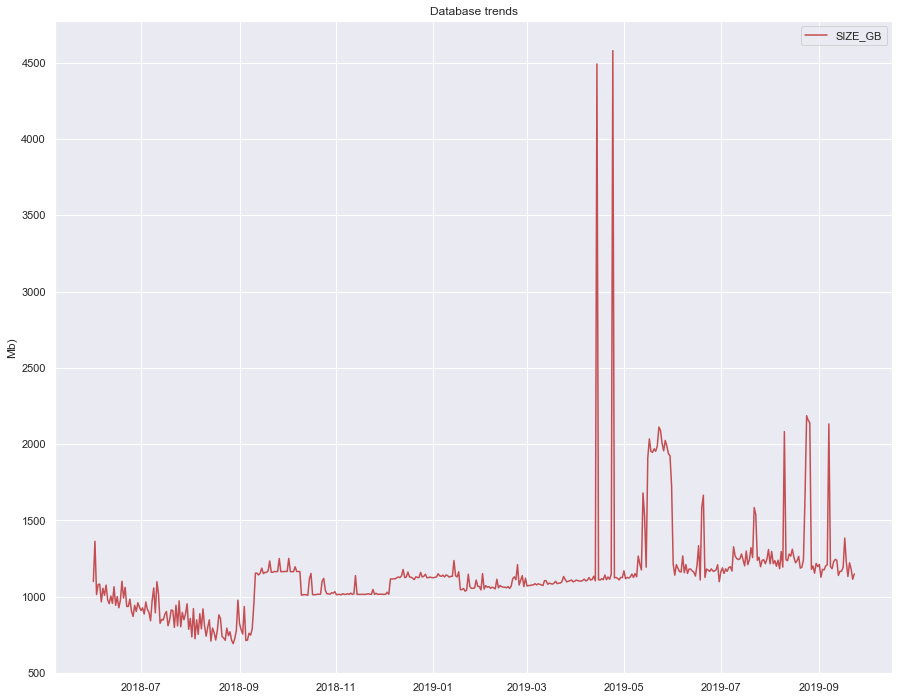

In [405]:
plt.figure(figsize=(15, 12))
plt.plot(sample.index, sample['SIZE_GB'], 'r-', label = 'SIZE_GB')
plt.title('Database trends')
plt.ylabel('Mb)');
plt.legend();
plt.show()

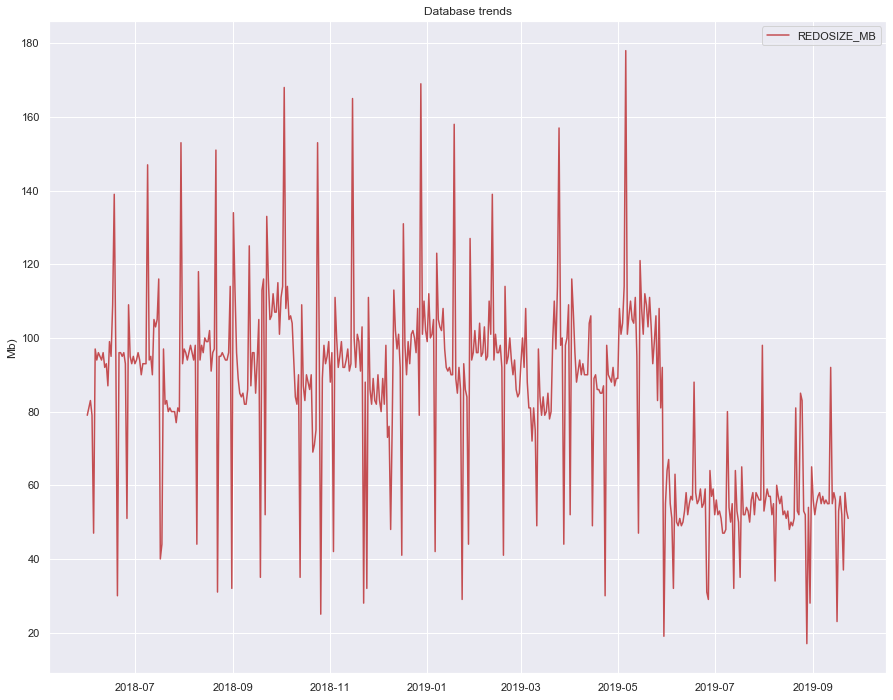

In [406]:
plt.figure(figsize=(15, 12))
plt.plot(sample.index, sample['REDOSIZE_MB'], 'r-', label = 'REDOSIZE_MB')
plt.title('Database trends')
plt.ylabel('Mb)');
plt.legend();
plt.show()

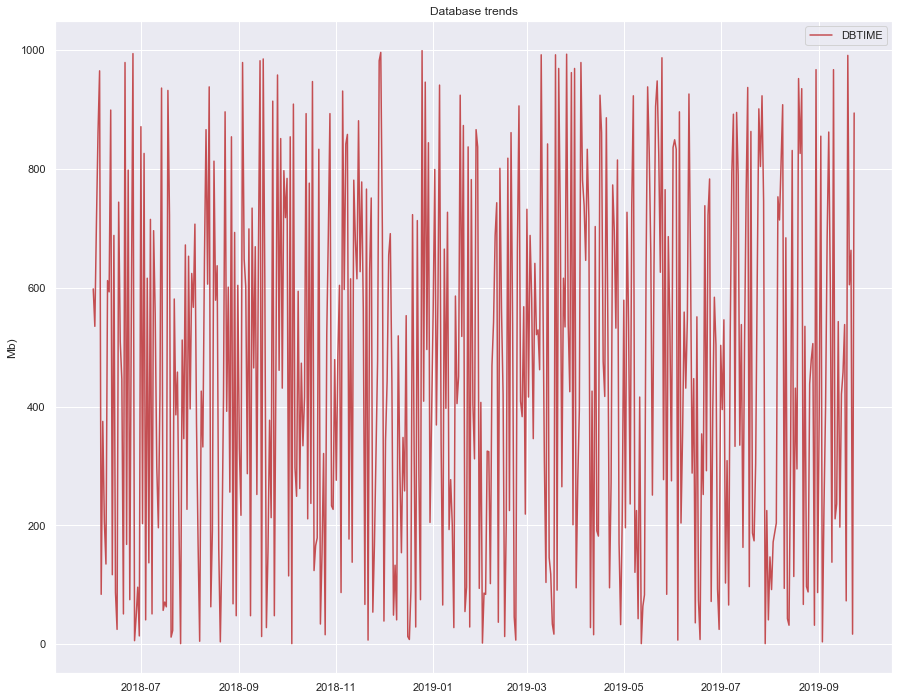

In [407]:
plt.figure(figsize=(15, 12))
plt.plot(sample.index, sample['DBTIME'], 'r-', label = 'DBTIME')
plt.title('Database trends')
plt.ylabel('Mb)');
plt.legend();
plt.show()

In [398]:
sample = sample.drop(['DBTIME','REDOSIZE_MB'], axis=1)
sample.rename(columns={"SIZE_GB": "value"}, inplace=True)

In [399]:
#проверка, чтобы не было пропущенных дат
pd.date_range(start = sample.index.min(), end = sample.index.max() ).difference(sample.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [400]:
sample.tail(20)

,database,value
rollup_timestamp,,
2019-09-04,18a35b7d-418a-4c7f-8d1c-8b3df052739c,1175.0
2019-09-05,18a35b7d-418a-4c7f-8d1c-8b3df052739c,1201.0
2019-09-06,18a35b7d-418a-4c7f-8d1c-8b3df052739c,1209.0
2019-09-07,18a35b7d-418a-4c7f-8d1c-8b3df052739c,2132.0
2019-09-08,18a35b7d-418a-4c7f-8d1c-8b3df052739c,1197.0
2019-09-09,18a35b7d-418a-4c7f-8d1c-8b3df052739c,1183.0
2019-09-10,18a35b7d-418a-4c7f-8d1c-8b3df052739c,1229.0
2019-09-11,18a35b7d-418a-4c7f-8d1c-8b3df052739c,1244.0
2019-09-12,18a35b7d-418a-4c7f-8d1c-8b3df052739c,1239.0


In [401]:
sample.to_csv('./input/sample_dbsize2.csv')